# ライブラリ

In [1]:
from IPython.display import Latex, display
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, transpile
from qiskit.circuit import Gate
from qiskit.extensions import MCXGate, UnitaryGate
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.providers.aer import QasmSimulator

# 計算基底符号化

### 2進符号化
$(-1.0, 1.0)$ の範囲の数を $digit$ 桁の精度で二進小数に変換

In [2]:
def binary_encoding(x: float, digit: int) -> str:
    bin = ""
    if x < 0:
        bin += "1"
        x *= -1
    else:
        bin += "0"
    for _ in range(digit-1):
        x *= 2
        if x >= 1:
            bin += "1"
            x -= 1
        else:
            bin += "0"
    return bin

### 入力重ね合わせ状態の準備
$\displaystyle\left|\mathcal{D}\right> = \frac{1}{\sqrt{M}}\sum_{m=1}^{M}\left|x^{m}\right>$ という状態を、使用するqubitの数 $N$ とデータ数 $M$ に関して線形の時間で用意

$\left|l_1, l_2, \dots, l_N; a_1, a_2; s_1, s_2, \dots, s_N\right>$ という $2N+2$ 個のqubitを用いて作成

In [3]:
def write_data(x: float, N: int, inverse: bool) -> Gate:
    qr_load = QuantumRegister(N)
    qc = QuantumCircuit(qr_load)
    bin = binary_encoding(x, N)
    for i, bit in enumerate(bin):
        if bit == "1":
            qc.x(qr_load[i])
    if inverse:
        return qc.inverse().to_gate(label="load data ^(-1)")
    return qc.to_gate(label="load data")


def copy_data(N: int, inverse: bool) -> Gate:
    qr_load = QuantumRegister(N)
    qr_store = QuantumRegister(N)
    qc = QuantumCircuit(qr_load, qr_store)
    for i in range(N):
        qc.cx(qr_load[i], qr_store[i])
    if inverse:
        return qc.inverse().to_gate(label="copy data ^(-1)")
    return qc.to_gate(label="copy data")


def all_same(N: int, inverse: bool) -> Gate:
    qr_load = QuantumRegister(N)
    qr_ancillary = QuantumRegister(2)
    qr_store = QuantumRegister(N)
    qc = QuantumCircuit(qr_load, qr_ancillary, qr_store)
    for i in range(N):
        qc.cx(qr_load[i], qr_store[i])
        qc.x(qr_store[i])
    qc.append(MCXGate(N), qr_store[:]+qr_ancillary[[0]])
    if inverse:
        return qc.inverse().to_gate(label="all same ^(-1)")
    return qc.to_gate(label="all same")


def input_superposition(X: np.ndarray, M: int, N: int, measure: bool) -> QuantumCircuit:
    qr_load = QuantumRegister(N, name="load")
    qr_ancillary = QuantumRegister(2, name="ancillary")
    qr_store = QuantumRegister(N, name="store")
    cr = ClassicalRegister(N, name="measure")
    qc = QuantumCircuit(qr_load, qr_ancillary, qr_store, cr)

    qc.x(qr_ancillary[1])
    for i in range(M):
        mu = M - i
        U = [[np.sqrt((mu-1) / mu), 1/np.sqrt(mu)], [-1/np.sqrt(mu), np.sqrt((mu-1) / mu)]]
        unitary_gate = UnitaryGate(U).control(1)
        qc.append(write_data(X[i], N, False), qr_load)
        qc.append(copy_data(N, False).control(1), qr_ancillary[[1]]+qr_load[:]+qr_store[:])
        qc.append(all_same(N, False), qr_load[:]+qr_ancillary[:]+qr_store[:])
        qc.append(unitary_gate, qr_ancillary)
        qc.append(all_same(N, True), qr_load[:]+qr_ancillary[:]+qr_store[:])
        qc.append(copy_data(N, True).control(1), qr_ancillary[[1]]+qr_load[:]+qr_store[:])
        qc.append(write_data(X[i], N, True), qr_load)
    if measure:
        qc.measure(qr_store, cr[::-1])
    return qc

### 回路図
出力が長いので省略 (コメントアウト)

In [4]:
N = 5
M = 8
X = np.random.rand(M) * 2 - 1
qc = input_superposition(X, M, N, False)
# qc.draw()

### 回路シミュレーション

In [5]:
backend = Aer.get_backend('statevector_simulator')
job = backend.run(transpile(qc, backend))
qc_state = job.result().get_statevector(qc)

### 確認
$x_i (i=1\dots M)$ に重複があるとおかしくなってしまうが、原因は不明

In [6]:
def display_state(state: np.ndarray, N: int) -> None:
    num_state = 2 ** (2*N+2)
    if len(state) != num_state:
        raise ValueError()

    # store ビットごとの確率に変換 Qiskit では順番が反転していることに注意
    store_state = state.reshape(2**N, -1).sum(axis=1)
    lines = array_to_latex(store_state, source=True, max_size=num_state+1).split("\n")
    for line in lines:
        if "&" in line:
            x_list = line.split(" & ")
            x_list[-1] = x_list[-1][:-4]  # ends with "  \\\\"
            break
    if len(x_list) != 2 ** N:
        raise ValueError()

    # 出力文字列作成
    outstr = r"$"
    second = False
    for i in range(len(x_list)):
        bin = np.binary_repr(i, width=N)
        ind = int(bin[::-1], 2)
        if x_list[ind] == "0":
            continue
        if second:
            outstr += " + "
        outstr += x_list[ind] + rf"\left|{bin}\right>"
        second = True
    outstr += r"$"
    display(Latex(outstr))
        

In [7]:
tmp_str = f"$\\begin{{array}}{{ll}}"
for i in range(M):
    tmp_str += f"x_{{{i+1}}} = {X[i]:.6f} & \\text{{bin}}: {binary_encoding(X[i], N)}\\\\"
display(Latex(tmp_str+f"\\end{{array}}$"))
display_state(qc_state, N)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### 観測確率からも確認
$x_i (i=1\dots M)$ に重複があると、 $\left|0\right>$ という状態が新たに追加され、挙動がおかしくなるのはこちらも同じ

鳩の巣原理を考えると、少なくとも $M > 2^{N}$ とはなってはならないという直感 (でなければ無限の情報量を詰め込めてしまう) は正しそうな気がするが...

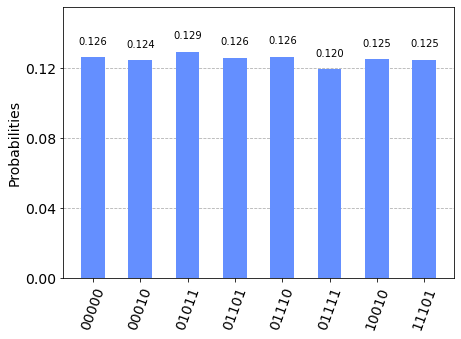

In [8]:
qc = input_superposition(X, M, N, True)
backend = QasmSimulator()
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=8192)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
plot_histogram(counts)